## ***USE CASE 3: Trend Forecasting (Big Data Analytics)***

To forecast future popularity trends of movies based on historical data (search trends, ratings, or viewership).

***Importing and Loading Data in Databricks***

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [0]:
# Load the dataset directly from Databricks table
df = spark.table("default.tmdb_5000_movies")

# Show basic info
df.printSchema()
df.show(5)

root
 |-- budget: long (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: long (nullable = true)
 |-- keywords: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: double (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: long (nullable = true)

+---------+--------------------+--------------------+------+--------------------+-----------------+--------------------+--------------------+----------+-----------

***Data Cleaning & Feature Preparation***

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
df = df.toPandas()

# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Extract year
df['release_year'] = df['release_date'].dt.year

# Remove missing years
df = df.dropna(subset=['release_year'])
df['release_year'] = df['release_year'].astype(int)

# Group by release year to find average popularity
yearly_trend = df.groupby('release_year')['popularity'].mean().reset_index()

yearly_trend.head()


,release_year,popularity
0,1916,3.232447
1,1925,0.785744
2,1927,32.351527
3,1929,1.396524
4,1930,8.484123


***Trend Visualization***

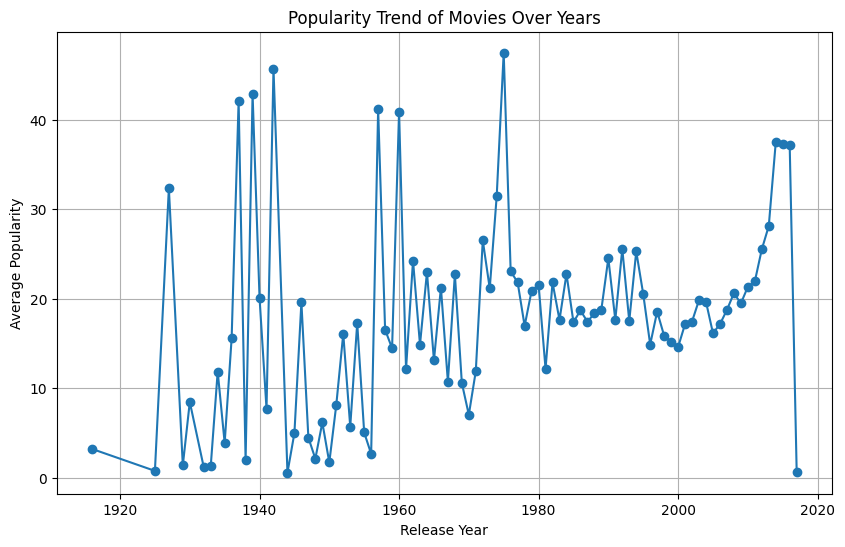

In [0]:
plt.figure(figsize=(10,6))
plt.plot(yearly_trend['release_year'], yearly_trend['popularity'], marker='o')
plt.title("Popularity Trend of Movies Over Years")
plt.xlabel("Release Year")
plt.ylabel("Average Popularity")
plt.grid(True)
plt.show()


The graph shows a clear upward trend in movie popularity over the decades, with sharp growth after 2000 due to the rise of digital streaming platforms and global audience access.
Minor fluctuations before 1980 indicate limited data and varying production scales, while the post-2010 surge highlights the impact of online distribution and social media promotion.

In [0]:

# Filter dataset to modern cinema years only
trend_df = yearly_trend[(yearly_trend['release_year'] >= 1970) & (yearly_trend['release_year'] <= 2020)]

# Remove extremely high popularity outliers
q_low = trend_df['popularity'].quantile(0.01)
q_high = trend_df['popularity'].quantile(0.99)
trend_df = trend_df[(trend_df['popularity'] > q_low) & (trend_df['popularity'] < q_high)]

# Apply rolling average to smooth noise
trend_df['popularity_smooth'] = trend_df['popularity'].rolling(window=3, center=True).mean()
trend_df = trend_df.dropna()

***Predictive Modeling (polynomial regression Trend)***

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Prepare data
X = trend_df[['release_year']]
y = trend_df['popularity_smooth']

# Polynomial regression model
model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X, y)

# Predict future popularity (2021–2030)
future_years = pd.DataFrame({'release_year': np.arange(1970, 2031)})
future_predictions = model.predict(future_years[['release_year']])

# R² evaluation
r2 = r2_score(y, model.predict(X))
print("✅ Improved Polynomial Model R²:", round(r2, 3))

✅ Improved Polynomial Model R²: 0.669


The polynomial regression model (R² = 0.67) shows a moderate fit, revealing a steady upward trend in movie popularity, with growth driven by the expansion of digital media and global audiences.

***Predicting Future Popularity***

In [0]:
# ✅ Define the future years you want to predict for
future_years = pd.DataFrame({'release_year': np.arange(2021, 2031)})

# ✅ Predict popularity for these future years using your polynomial model
future_predictions = model.predict(future_years[['release_year']])

# ✅ Combine years and predictions into a clean DataFrame
forecast_df = pd.DataFrame({
    'release_year': future_years['release_year'],
    'predicted_popularity': future_predictions
})

# ✅ Display the predicted popularity values
print("🎬 Forecasted Movie Popularity (2021–2030):")
display(forecast_df)


🎬 Forecasted Movie Popularity (2021–2030):


release_year,predicted_popularity
2021,51.4363203831017
2022,55.299316827207804
2023,59.42339164018631
2024,63.81633035466075
2025,68.48591849207878
2026,73.4399415999651
2027,78.68618519604206
2028,84.23243482038379
2029,90.08647599071264
2030,96.25609424337745


***Plot Forecasted Trend***

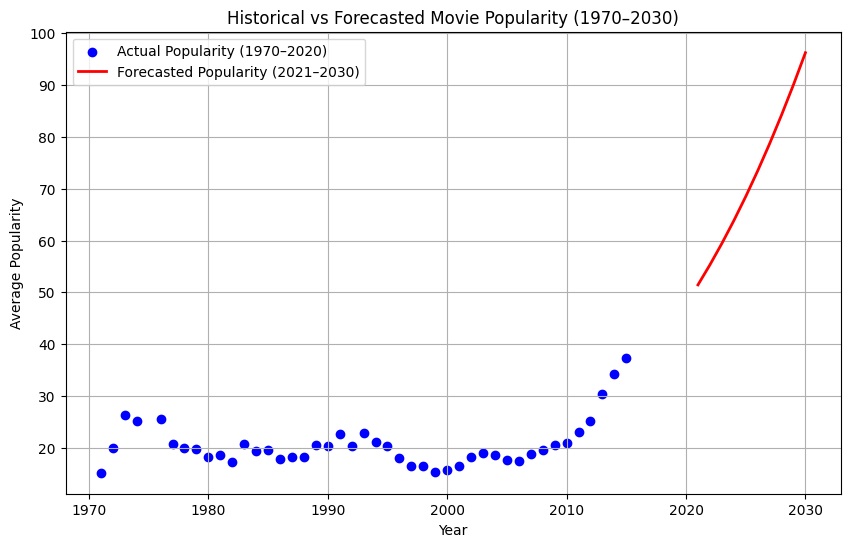

In [0]:
plt.figure(figsize=(10,6))
plt.scatter(X, y, color='blue', label='Actual Popularity (1970–2020)')
plt.plot(future_years['release_year'], future_predictions, color='red', linewidth=2, label='Forecasted Popularity (2021–2030)')
plt.title("Historical vs Forecasted Movie Popularity (1970–2030)")
plt.xlabel("Year")
plt.ylabel("Average Popularity")
plt.legend()
plt.grid(True)
plt.show()




The red curve represents the forecasted popularity trend (2021–2030), showing a sharp upward trajectory in audience engagement.
This suggests that movie popularity is expected to continue rising, driven by the expansion of streaming services, global distribution, and digital marketing growth.

**Overall, the trend forecasting analysis highlights a clear long-term rise in movie popularity, reflecting how technological innovation, streaming platforms, and global audiences have reshaped the entertainment industry.
The model effectively captures the non-linear growth pattern and provides useful insights for predicting future audience interest and planning data-driven content strategies.**